In [431]:
import subprocess
from multiprocessing import Pool,cpu_count
import os,sys
from itertools import product,repeat
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline,interp2d,RectBivariateSpline,SmoothBivariateSpline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
import fileinput as fi
from sklearn.decomposition import PCA
from peaks import *
import seaborn as sns
import pickle as pkl


%run averaging.ipynb
%run optimize_slope.ipynb

ncores=cpu_count()

ERROR:root:File `'averaging.ipynb.py'` not found.
ERROR:root:File `'optimize_slope.ipynb.py'` not found.


In [2]:
area_er = 2*(3.9+0.1+0.1*0.1+3.9*0.1)
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e2

In [432]:
res_loc="/media/kabir/ca_binding"#clamped_archive_murthy_full_mcell"#VDCCsweep"
#res_loc="/media/kabir/VDCCsweep"
result={}


sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x","stores_blocked"]

VDCC_range=range(60,200,20)
isi_range=range(20,181,40)
fnames=['RSI%d'%i +'V%d'%v for i,v in product(isi_range,VDCC_range)]


better_sim_names = {
    "ryr_old":"old model",
    "stores_blocked":"stores blocked",
    "R150control":"Physiological Control", 
    "R150ER2x":"Normal RyR, Double ER Calcium",
    "R150ER3x":"Normal RyR, Triple ER Calcium",
    "R300ER3x":"Double RyR, Triple ER Calcium",
    "R300ER2x":"Double RyR, Double ER Calcium"
    
}

fnames

print(VDCC_range,isi_range)

range(60, 200, 20) range(20, 181, 40)


In [260]:
class data_collector:
    def __init__(self,res_loc,sims,fnames):
        self.res_loc=res_loc
        self.sims=sims
        self.fnames=fnames
    
    def load(self,sim,fname,file_type='ca.dat',cols=1,step=2,contains=None):
        loc=os.path.join(self.res_loc,sim,fname)
        seeds=os.listdir(loc)
        temp_list=[]
        if not contains==None:
            seeds=[s for s in seeds if contains in s]
        for seed in seeds:
            file_loc=os.path.join(loc,seed,'dat',file_type)
            temp_list.append(np.genfromtxt(file_loc, unpack=True)[cols,:])
        
        time = np.genfromtxt(file_loc, unpack=True)[0,:]
        if file_type=='ca_hits.dat':
            temp_list=[np.sort(temp) for temp in temp_list]
            return time, temp_list
        data = np.stack(temp_list,axis=1)
        #print(time.shape,data.shape)
        #conc=(np.tile(time[step::step],(data.shape[1],1)).T*data[step::step]-np.tile(time[0:-step:step],(data.shape[1],1)).T*data[0:-step:step])/(time[step]-time[0])
        #time = time[:-step:step]    
        
        return time,data

    def load_all(self,file_type='ca.dat',cols=1):
        self.data=dict(zip(self.sims,[{}]*len(self.sims)))
        self.time=dict(zip(self.sims,[{}]*len(self.sims)))
        
        for sim,fname in product(sims,fnames):
            self.time[sim][fname],self.data[sim][fname]=self.load(sim,fname,file_type=file_type,cols=cols)


In [193]:
loc="/media/kabir/ca_hits.dat"
hit_times=np.sort(np.loadtxt(loc,delimiter=' ',usecols=0))

In [33]:
res_loc="/data/kabir/output/ppf/clamped/R150control/RSI100V100/s_00001/dat/ca.dat"
ca=np.loadtxt(loc,delimiter=' ',usecols=1)

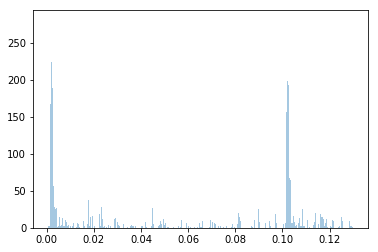

In [99]:
sns.distplot(hit_times,bins=500, kde=False)

In [98]:
isi=100 #ms
interval=4
bin1=np.sum((hit_times>=0.002)*(hit_times<=0.002+interval*1e-3))
bin2=np.sum((hit_times>=0.002+isi*1e-3)*(hit_times<=0.002+(isi+interval)*1e-3))
print(bin1,bin2)

783 988


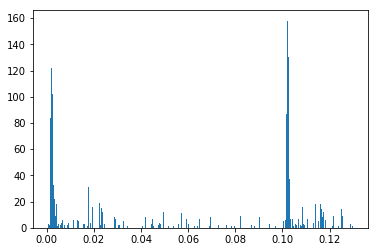

In [100]:
hist=plt.hist(hit_times,bins=1000)

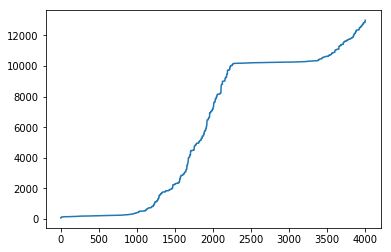

In [116]:
bins=np.arange(0,130e-3,10e-6)
dig=np.digitize(hit_times,bins)
plt.plot(dig)

In [524]:
res_loc="/media/kabir/ca_binding"
D=data_collector(res_loc=res_loc,sims=sims,fnames=fnames)
sim=sims[0]
fname=fnames[0]
not_useful,hit_times=D.load(sim,"RSI20V160",file_type='ca_hits.dat',cols=0,contains=None)
time,ca=D.load(sim,"RSI20V160",file_type='ca.dat',cols=1,contains=None)

In [525]:
inters=np.zeros((len(hit_times),len(time)))
for i,series in enumerate(hit_times):
    nseries=np.concatenate((np.zeros(1),series,time[-1:]))
    dig=np.digitize(time,series)
    inters[i,:]=nseries[dig+1]-nseries[dig]
    
mean,std=np.average(inters,axis=0),np.std(inters,axis=0)

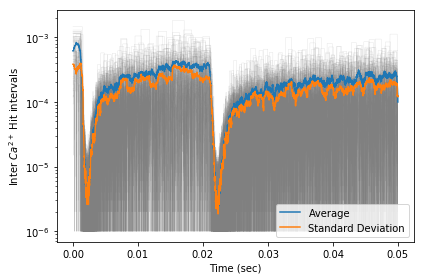

In [526]:
for i in range(inters.shape[0]):
    plt.plot(time,inters[i,:],lw=0.3,alpha=0.3,color='gray')
plt.plot(time,mean,label="Average")
plt.plot(time,std,label="Standard Deviation")
plt.ylabel("Inter $Ca^{2+}$ Hit intervals")
plt.xlabel("Time (sec)")
plt.yscale('log')
plt.tight_layout()
plt.legend()

plt.savefig("../plots/inter_hit_time_vdcc160_log.pdf")

In [499]:
def gen_hit_times_from_mean(mean,time):
    hit_times=[]
    cum=0
    while(cum<time[-1]):
        beta=mean[np.searchsorted(time,cum)]
        interval=np.random.exponential(beta)
        cum+=interval
        hit_times.append(cum)
    return hit_times[:-1]

In [372]:
gen_hit_times=[]
for i in range(50):
    gen_hit_times.append(gen_hit_times_from_mean(mean,time))

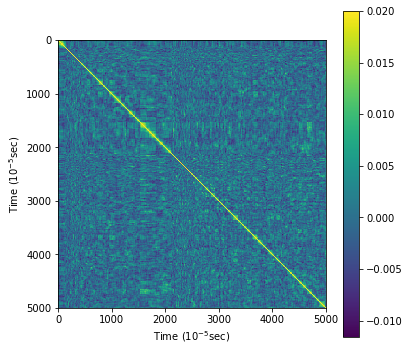

In [537]:
X=(inters-np.average(inters,axis=0))/50/np.std(inters,axis=0)
C=np.dot(X.T,X)
fig=plt.figure(figsize=(6,6))
im=plt.imshow(C)
plt.xlabel("Time ($10^{-5}$sec)")
plt.ylabel("Time ($10^{-5}$sec)")
plt.colorbar(im)
plt.savefig("../plots/autocorrelationvdcc60.pdf")

In [540]:
res_loc="/media/kabir/clamped_archive_murthy_full_mcell"#ca_binding
D=data_collector(res_loc=res_loc,sims=sims,fnames=fnames)
sim=sims[0]
fname=fnames[0]
timem,state=D.load(sim,"RSI_20",file_type='az.dat',cols=tuple(range(1,19)),contains="V98")

In [541]:
res_loc="/media/kabir/ca_binding"
D=data_collector(res_loc=res_loc,sims=sims,fnames=fnames)
sim=sims[0]
fname=fnames[0]
timem,state=D.load(sim,"RSI20V100",file_type='az.dat',cols=tuple(range(1,19)))#,contains="RSI20V60")

In [538]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/STEPS_AZ/hits_6May2020/"
#res_loc="/home/kabir/Project/tripartiteSynapse/results/STEPS_AZ/2May2020/"
sim=sims[0]
fname=fnames[0]
az_data=np.genfromtxt(os.path.join(res_loc,sim,"isi20/vdcc60/az.dat"))#isi20/
time,az=az_data[:,0],az_data[:,1:19]

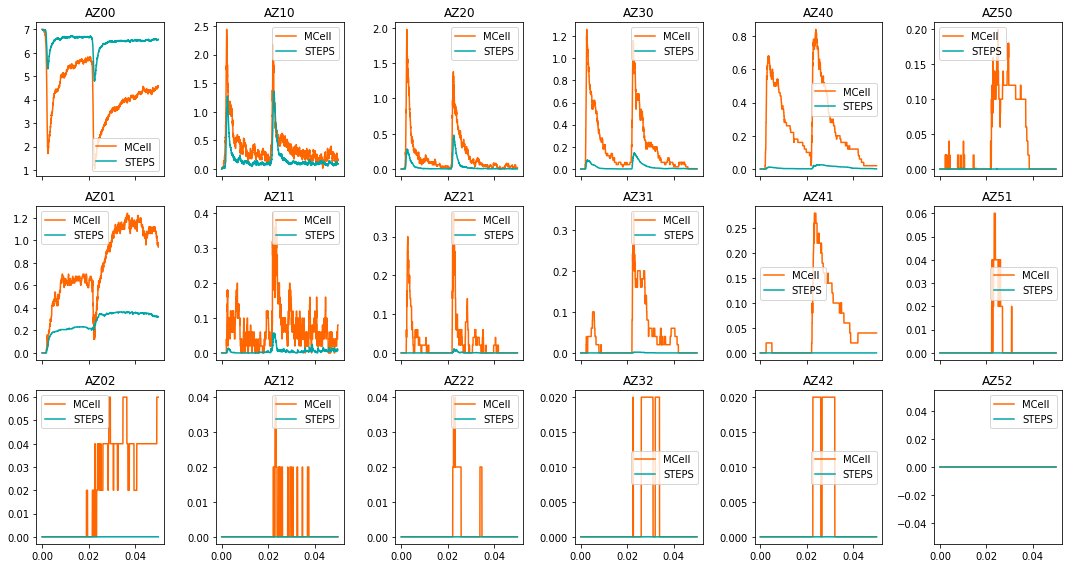

In [542]:
fig,axs=plt.subplots(3,6,figsize=(15,8),sharex=True)
c1,c2="#FF6600","#00a5a5"
titles="AZ00	AZ10	AZ20	AZ30	AZ40	AZ50	AZ01	AZ11	AZ21	AZ31	AZ41	AZ51	AZ02	AZ12	AZ22	AZ32	AZ42	AZ52".split("\t")

for i,ax in enumerate(axs.flatten()):
    ax.plot(timem,np.average(state[i,:,:],axis=0),label="MCell",c=c1)
    ax.plot(time,az[:,i],label="STEPS",c=c2)
    ax.set_title(titles[i])
    ax.legend()
plt.tight_layout()    
#plt.savefig("../plots/azmol_STEPSandMCell_vdcc60_hitsCa_4May2020.pdf")#delta_1e-8_1May.pdf

In [622]:
#res_loc="/home/kabir/Project/tripartiteSynapse/results/ppdf/14apr2020/"
res_loc="/home/kabir/Project/tripartiteSynapse/results/STEPS_AZ/2May2020/"
sim=sims[0]
fname=fnames[0]
az_data=np.genfromtxt(os.path.join(res_loc,sim,"isi20/vdcc100/az.dat"))#isi20/
time,az=az_data[:,0],az_data[:,1:19]

In [616]:
res_loc="/media/kabir/ca_binding"
D=data_collector(res_loc=res_loc,sims=sims,fnames=fnames)
sim=sims[0]
fname=fnames[0]
time,conc=D.load(sim,"RSI20V60",file_type='ca.dat',cols=1,contains=None)

In [650]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/14apr2020/R150control/RSI20V160/azCaConc.dat"
ca=np.genfromtxt(res_loc,unpack=True).T[:,[0,2]]
time,ca=ca[:,0],ca[:,1]

In [654]:
conc=ca
#conc=time[1:]*conc[1:]-time[:-1]*conc[:-1]
#conc=conc*(conc>0)
#conc=conc/(time[1]-time[0])

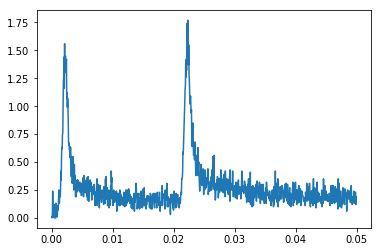

In [655]:
plt.plot(time,ca)

In [656]:
cum=np.cumsum(conc)*(time[1]-time[0])

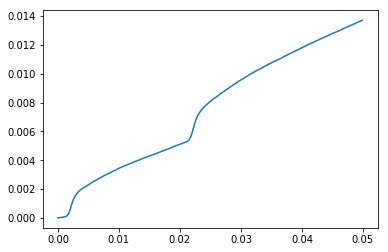

In [657]:
plt.plot(time,cum)

0.001


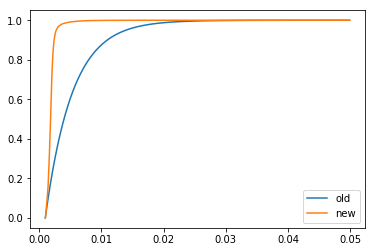

In [725]:
l,u=20,1000
print(time[l])
p_new=1-np.exp(-5*0.6e8*7*1e-6*(cum[l:u]-cum[l]))
p_old=1-np.exp(-5*0.6e8*7*1e-6*conc[l]*(time[l:u]-time[l]))
#p_new=(p_new[l+1:u]-p_new[l:u-1])/time[1]
#p_old=(p_new[l+1:u]-p_new[l:u-1])/time[1]
plt.plot(time[l:u],p_old,label="old")
plt.plot(time[l:u],p_new,label="new")
plt.legend()

IndexError: too many indices for array

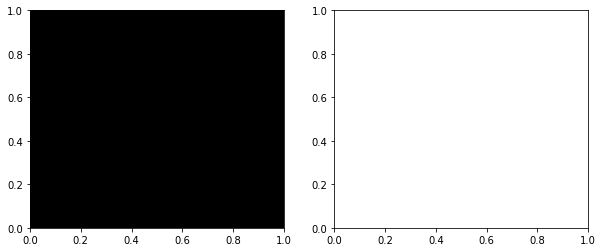

In [559]:
fig,axs=plt.subplots(1,2,figsize=(10,4))

average=np.average(conc,axis=(0,1))
##########################################
axs[0].patch.set_facecolor('black')

for i in range(conc.shape[1]):
    axs[0].plot(time,np.average(conc[:,i,:],axis=0),color='white',alpha=0.5,lw=0.1)
    
axs[0].plot(time,average,'red',lw=1)

data=(conc[:,:,1:]-conc[:,:,:-1])#/(time[1]-time[0])

average=np.average(data,axis=(0,1))*54
##########################################
axs[1].patch.set_facecolor('black')

for i in range(conc.shape[1]):
    axs[1].plot(time[:-1],np.sum(data[:,i,:],axis=0),color='white',alpha=0.5,lw=0.1)
    
axs[1].plot(time[:-1],average,'red',lw=1)

#plt.savefig("../plots/ca_binding_26042020.pdf")

In [439]:
with open("map.pkl",'rb') as f:
    MAP=pkl.load(f)

In [102]:
from MFB_model import *

In [103]:
mdl=smodel.Model()

cytssys = smodel.Surfsys('cytSurfsys',mdl)

Ca = smodel.Spec('Ca', mdl)

azMol, R_AZ=get_AZ(cytssys,mdl,Ca)

In [104]:
bind_reac=[]
for k in R_AZ.keys():
    if Ca in R_AZ[k].ilhs:
        bind_reac.append(k)

In [437]:
rate_const=np.array([R_AZ[reac].kcst for reac in bind_reac])
rate_const.shape

(54,)

In [456]:
res_loc="/media/kabir/ca_binding"
D=data_collector(res_loc=res_loc,sims=sims,fnames=fnames)
sim=sims[0]
fname=fnames[0]
time,data=D.load(sim,"RSI20V60",file_type='ca_sensor_binding.dat',cols=tuple(range(1,55)),contains=None)
data=(data[:,:,1:]-data[:,:,:-1])/(time[1]-time[0])

In [465]:
trial=2
rate_state_mapping=[MAP[i] for i in range(1,55)]
ca=data[:,:,:]/state[rate_state_mapping,:,:-1]
ca[np.isnan(ca)]=0
#ca=ca*(state[rate_state_mapping,0,:-1]==0)
print(np.tile(rate_const,(ca.shape[2],50,1)).T.shape)
ca=ca/np.tile(rate_const,(ca.shape[2],50,1)).T

ca=np.sum(ca,axis=0)/np.sum(state[rate_state_mapping,:,:-1]!=0,axis=0)

/home/kabir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kabir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


(54, 50, 5000)


In [210]:
ca.shape

(50, 5000)

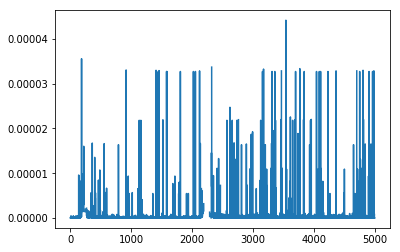

In [461]:
plt.plot(np.average(ca,axis=0))
#plt.savefig("../plots/ca_reconst_bindinf_reac_27042020.pdf")

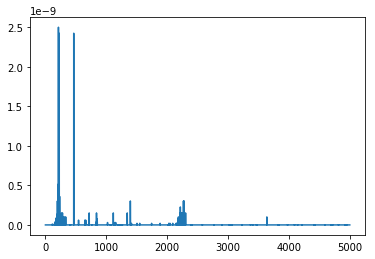

In [167]:
plt.plot(np.average(ca,axis=0))

In [155]:
np.zeros(1)/np.zeros(1)

/home/kabir/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([nan])

In [116]:
np.argmax(np.average(data,axis=(0,1)))

214

In [105]:
l=0
r=np.sum(data[:,1,210]*np.exp(-(time[1]-time[0])*(data[l,1,210]-data[:,1,210])))
approx_r=np.sum(data[:,1,210])
print(r,approx_r)

3.0000500004500026 3.0


In [52]:
np.sum(data[:,:,214]==2)/np.sum(data[:,:,214])

0.018867924528301886

In [96]:
print("Delta T",time[1]-time[0])

Delta T 1e-05


In [87]:
np.max(data)

3.0

In [84]:
data.shape

(54, 50, 5000)

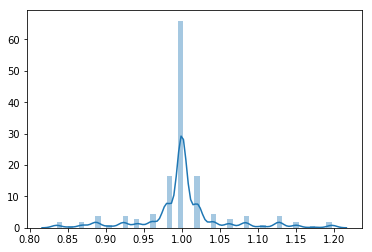

In [92]:
i,j=0,1
#Rij=np.zeros((data.shape[0],data.shape[0]))

rates=np.tile(np.average(data[:,:,214]>=1,axis=1),(data.shape[0],1))
R=rates-rates.T
sns.distplot(np.exp(R.flatten()))
plt.savefig("../plots/expRi_Rjdist.pdf")
#-np.average(data[j,:,214]>=1,axis=1))
#plt.plot()

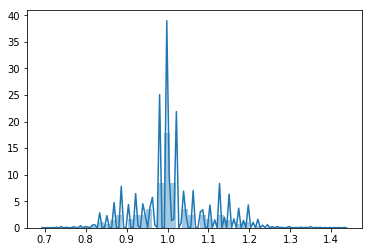

In [95]:
Rsums=(rates+rates.T).flatten()
Rdiff=np.tile(Rsums,(data.shape[0]**2,1))
Rijkl=np.exp(Rdiff-Rdiff.T).flatten()
sns.distplot(Rijkl)

0
0.0


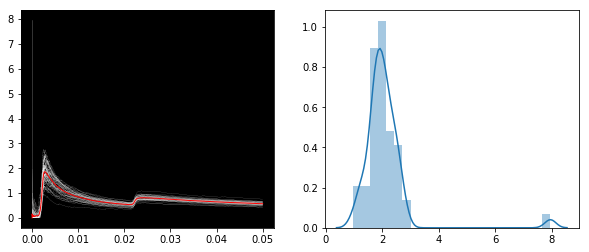

In [450]:
res_loc="/media/kabir/ca_binding"
D=data_collector(res_loc=res_loc,sims=sims,fnames=fnames)
sim=sims[0]
time,conc=D.load(sim,"RSI20V60",file_type='ca.dat',cols=1,contains=None)

fig,axs=plt.subplots(1,2,figsize=(10,4))

average=np.average(conc,axis=1)
##########################################
axs[0].patch.set_facecolor('black')

for i in range(conc.shape[1]):
    axs[0].plot(time,conc[:,i],color='white',alpha=1,lw=0.1)
    
axs[0].plot(time,average,'red',lw=1)
print(np.sum(np.sign(conc)==-1))
#axs[0].set_ylim((0,15))
##########################################
print(np.min(conc))
peak=np.max(conc,axis=0)

sns.distplot(peak,ax=axs[1])


#fig.savefig("stoch_ca_AZ.pdf")

In [110]:
conc.shape

(500, 104)

In [79]:
data.shape

(5001, 104)

In [100]:
np.any(np.sign(np.tile(np.arange(50),(3,1)))==-1)

False

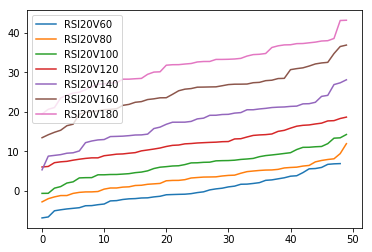

In [139]:
for v in range(60,181,20):
    time,data=D.load("R150control","RSI20V%d"%v,file_type='ca.dat',cols=1)
    step=20
    conc=(np.tile(time[step::step],(data.shape[1],1)).T*data[step::step]-np.tile(time[0:-step:step],(data.shape[1],1)).T*data[0:-step:step])/(time[step]-time[0])
    trans=pca.transform(conc.T)
    plt.plot(sorted(trans[:,0]),label="RSI20V%d"%v)#,trans[:,1]
    #plt.plot(trans[:,0],trans[:,1],'o',label="RSI20V%d"%v)#,trans[:,1]
plt.legend()

In [138]:
p=PCA()
pca=p.fit(conc.T)

In [135]:
conc.T.shape

(50, 2500)

In [13]:
plt.plot(np.linalg.norm(pca,axis=0))

AttributeError: 'PCA' object has no attribute 'conjugate'

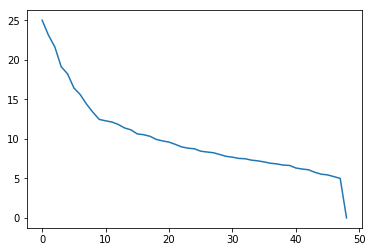

In [140]:
plt.plot(pca.singular_values_)

In [122]:
pca.singular_values_[0:4]

array([387.6793141 , 130.76587715, 127.51142649, 126.55258366])